### Домашняя работа №2

In [1]:
#В данной работе использую Python 3.9.13 и tensorflow 2.7.0

import sys
import tensorflow as tf
from tensorflow import keras 

# Вывод версий Python и Tensorflow
print("Python", sys.version)
print("Tensorflow", tf.__version__)

# Убеждаюсь, что tensorflow использует GPU
available_gpus = tf.config.list_physical_devices('GPU') # Динамическое использование памяти GPU
if available_gpus:
    try:
        for gpu in available_gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Tensorflow uses GPU")
    except RuntimeError as error:
        print("GPU Error:", error)

Python 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Tensorflow 2.7.0
Tensorflow uses GPU


In [2]:
import numpy as np
import re

path = keras.utils.get_file('pride_and_prejudice.txt', origin='https://www.gutenberg.org/files/1342/1342-0.txt')

#Обработка текста
text = open(path, encoding='utf-8').read().lower()
text = text.replace('\n', ' ') # Заменяю переходы на новую строку пробелами

#Отбрасываем оглавление и служебную информацию
start = text.find("preface.")
end = text.find("end of the project gutenberg ebook")
text = text[start:end]

#Отбрасываем служебные отметки в кавычках [...]
text = re.sub(r'\[.*?\]', '', text)

#Убираем множественные пробелы
text = re.sub(r'\s+', ' ', text)

print('Corpus length:', len(text))

Corpus length: 712148


In [3]:
# Извлечение последовательностей по 60 символов
maxlen = 60

# Новые последовательности выбираются через каждые 3 символа
step = 3

# Хранение извлеченных последовательностей
sentences = []

#Хранение целей (символов, следующих за последовательностями)
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# Список уникальных символов в корпусе
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))

#Словарь,отображающий уникальные символы в их индексы в списке «chars»
char_indices = dict((char, chars.index(char)) for char in chars)
print('Vectorization...')

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    # Прямое кодирование символов в бинарные массивы
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 237363
Unique characters: 59
Vectorization...


In [4]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(maxlen,len(chars))))
model.add(keras.layers.Dense(len(chars), activation='softmax'))

# Конфигурация компилируемой модели
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [5]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature #Добавляю 1e-8 чтобы избежать логарифма от нуля в случае preds==0
    exp_preds = np.exp(preds) 
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
import random
import sys
import os

#Директория для сохранения сгенерированных текстов
OUTPUT_DIR = "generated_text"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#Количество эпох
EPOCHS = 60

#Будем сохранять потери
losses = []

# Обучение модели
for epoch in range(1, EPOCHS + 1):
    print('Epoch', epoch)
    #Выполнение одной итерации обучения
    history = model.fit(x, y, batch_size=128, epochs=1)
    losses.append(history.history['loss'][0])

    # Выбор случайного начального текста
    start_index = random.randint(0, len(text) - maxlen - 1)
    seed_text = text[start_index: start_index + maxlen]
    
    #Открытие файла для записи
    filename = f"epoch_{epoch:02}.txt"
    filepath = os.path.join(OUTPUT_DIR, filename)
    
    with open(filepath, "w", encoding="utf-8") as file:
        print("Generating to file:", filename)
        print()
        file.write(f"Epoch: {epoch}\n\n")
        file.write(f"Generating with seed:\n{seed_text}\n\n")
    
        # Генерация текста для разных температур
        for temperature in [0.2, 0.5, 1.0, 1.2]:
            full_gen = seed_text #Полный сгенерированный текст для записи в файл
            generated_text = seed_text
            
            # Генерация 400 символов, начиная с начального текста
            for i in range(400):
            # Прямое кодирование символов, сгенерированных до сих пор
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.
                    
                # Выбор следующего символа
                preds = model.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]
                
                generated_text += next_char
                generated_text = generated_text[1:]
                full_gen += next_char
                
            file.write("-"*50 + "\n")
            file.write(f"Temperature: {temperature}\n\n")
            file.write(full_gen + "\n\n")
            
model.save("char_lstm_model.h5")

Epoch 1
1855/1855 [==============================] - 19s 9ms/step - loss: 1.7661
Generating to file: epoch_01.txt

Epoch 2
1855/1855 [==============================] - 16s 9ms/step - loss: 1.4142
Generating to file: epoch_02.txt

Epoch 3
1855/1855 [==============================] - 16s 9ms/step - loss: 1.3329
Generating to file: epoch_03.txt

Epoch 4
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2944
Generating to file: epoch_04.txt

Epoch 5
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2689
Generating to file: epoch_05.txt

Epoch 6
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2511
Generating to file: epoch_06.txt

Epoch 7
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2367
Generating to file: epoch_07.txt

Epoch 8
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2255
Generating to file: epoch_08.txt

Epoch 9
1855/1855 [==============================] - 16s 9ms/step - loss: 1.2138

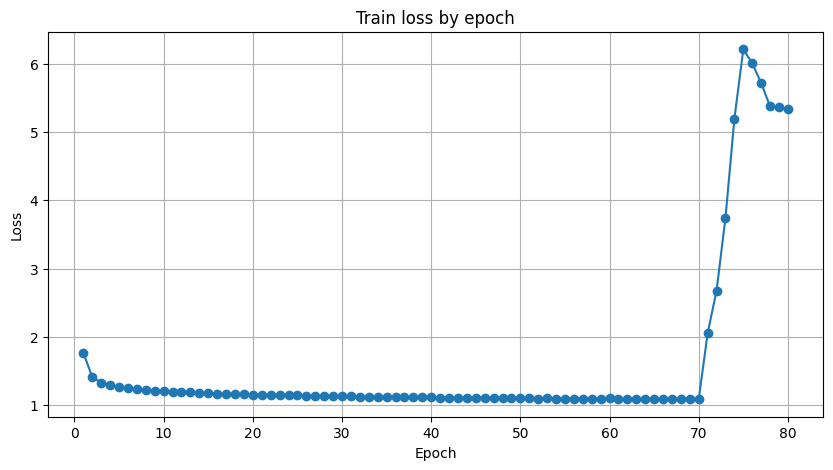

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title("Train loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()